In [1]:
import sys
sys.path.append('/Users/mariana/Documents/projects/Graphs/egnn')

In [2]:
from ae_datasets import d_selector, Dataloader
from ae_datasets.d_creator import max_n_nodes, DatasetCommunity, DatasetErdosRenyiNodes
import graph as gl

In [3]:
import networkx as nx

In [20]:
import numpy as np
from torch.nn import functional as F

In [5]:
import matplotlib.pyplot as plt

In [6]:
# dataset_name = 'erdosrenyinodes_0.15_none'
dataset_name = 'community_ours'

In [118]:
dataset = d_selector.retrieve_dataset(dataset_name, K=2, with_pos=False, n_nodes=100, directed=True, num_communities=6)

Creating dataset with  6  communities


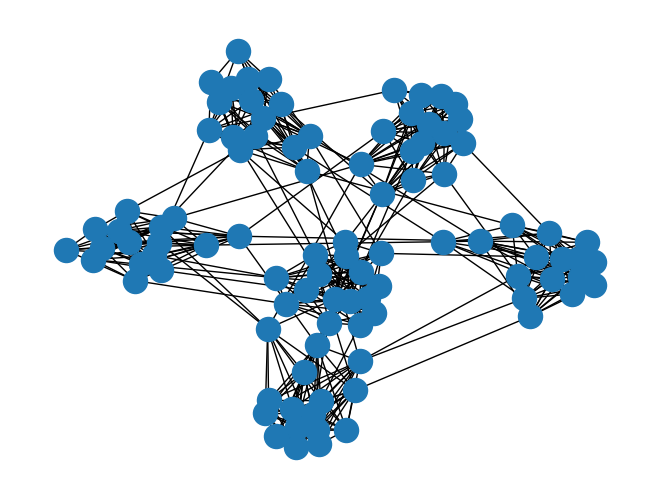

In [120]:
gl.plot_graph(dataset.graphs[22])

In [8]:
def laplacian(adj):
    return np.diag(adj.sum(1)) - adj

def adj_from_lap(lap):
    D = np.diag(np.diag(lap))
    return D - lap

In [80]:
a2 = adj_from_lap(laplacian(adj))

In [81]:
( a2 == adj).all()

True

In [9]:
def spectrum(mat, return_val=False):
    val, vec = np.linalg.eig(mat)
    idx = val.argsort()[::-1]   
    val = val[idx]
    vec = vec[:, idx]
    sqr_val = np.sqrt(val)
    sqr_val[np.isnan(sqr_val)] = 0.0
    vec = vec @ np.diag(sqr_val)
    if return_val:
        res = (vec, val)
    else:
        res = vec
    return res

In [46]:
def aprox(vec, K):
    return vec[:, :K] @ vec[:,:K].T

def mse(gt, pred):
    return ((gt - pred)**2).mean()

# def adjacency_error(adj_pred, adj_gt):
#     n_nodes = adj_gt.size(0)
#     adj_pred = (adj_pred > 0.5).type(torch.float32)
#     adj_errors = torch.abs(adj_pred - adj_gt)
#     wrong_edges = torch.sum(adj_errors)
#     adj_error = wrong_edges/ (n_nodes ** 2 - n_nodes)
#     return wrong_edges.item(), adj_error.item()

def adjacency_error(adj_pred, adj_gt):
    n_nodes = adj_gt.shape[0]
    adj_pred = (adj_pred > 0.5).astype(float)
    adj_errors = np.abs(adj_pred - adj_gt)
    wrong_edges = np.sum(adj_errors)
    adj_error = wrong_edges/ (n_nodes ** 2 - n_nodes)
    return wrong_edges, adj_error

def adj_bce(pred, gt):
    pred = np.clip(pred, 1e-7, 1 - 1e-7)
    term_0 = (1-gt) * np.log(1-pred + 1e-7)
    term_1 = gt * np.log(pred + 1e-7)
    return -np.sum(term_0+term_1)

In [85]:
adjacency_error(adj, adjs[3])

(46.0, 0.1503267973856209)

In [121]:
adjs = []
for graph in dataset.graphs:
    _, _, _, adj_gt = graph.get_dense_graph(store=True, loops=False)
    adjs.append(adj_gt.numpy())

In [122]:
laps = []
for adj in adjs:
    laps.append(laplacian(adj))

In [123]:
eig = []
for lap in laps:
    vec = spectrum(lap)
    eig.append(vec)

/var/folders/gy/r509yr655150tg12h1t9h_tr0000gn/T/ipykernel_59944/4079672761.py:6: RuntimeWarning: invalid value encountered in sqrt
  sqr_val = np.sqrt(val)


In [124]:
# K = 3
# approximations = []
# for vec in eig:
#     approximations.append(aprox(vec, K))

In [125]:
# len(approximations)

In [126]:
# Ks = [3, 8, 13, 16] For n_nodes = 20
Ks = [3, 10, 20, 50, 80, 90, 100]

d = dict()

for K in Ks:
    
    approximations = []
    for vec in eig:
        approximations.append(aprox(vec, K))
        
    aerrs = []
    for adj_gt, apr in zip(adjs, approximations):
        adj_pred = adj_from_lap(apr)

        _, aerr = adjacency_error(adj_pred, adj_gt)
        aerrs.append(aerr)
    
    d[K] = np.array(aerrs)

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

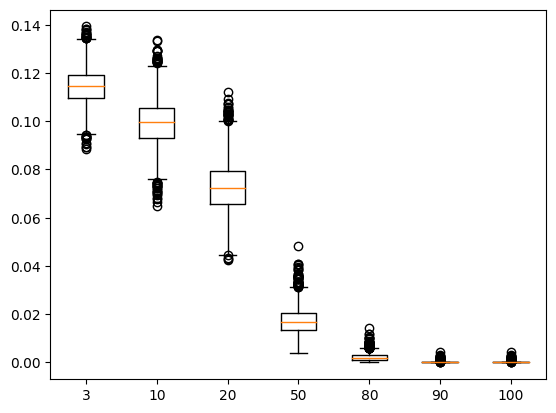

In [127]:
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())

In [7]:
#Check reconstruction error from eigenvectors
#--------------------------------------------

dataset = d_selector.retrieve_dataset(dataset_name, K=3, with_pos=False, n_nodes=100, directed=True)

Creating dataset with  2  communities


In [11]:
adjs = []
for graph in dataset.graphs:
    _, _, _, adj_gt = graph.get_dense_graph(store=True, loops=False)
    adjs.append(adj_gt.numpy())

laps = []
for adj in adjs:
    laps.append(laplacian(adj))

eig = []
for lap in laps:
    vec = spectrum(lap)
    eig.append(vec)

/var/folders/gy/r509yr655150tg12h1t9h_tr0000gn/T/ipykernel_1096/4079672761.py:6: RuntimeWarning: invalid value encountered in sqrt
  sqr_val = np.sqrt(val)


In [12]:
# Ks = [3, 8, 13, 16] For n_nodes = 20
Ks = [3, 10, 20, 50, 80, 90, 100]

d = dict()

for K in Ks:
    
    approximations = []
    for vec in eig:
        approximations.append(aprox(vec, K))
        
    aerrs = []
    for adj_gt, apr in zip(adjs, approximations):
        adj_pred = adj_from_lap(apr)

        _, aerr = adjacency_error(adj_pred, adj_gt)
        aerrs.append(aerr)
    
    d[K] = np.array(aerrs)

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

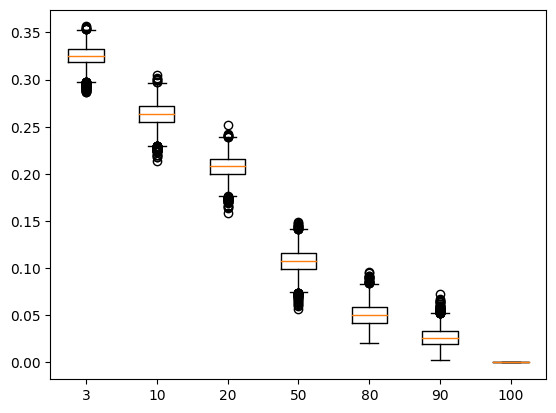

In [13]:
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())

In [51]:
# Ks = [3, 8, 13, 16] For n_nodes = 20
Ks = [3, 10, 20, 50, 80, 90, 100]

d = dict()

for K in Ks:
    
    approximations = []
    for vec in eig:
        approximations.append(aprox(vec, K))
        
    aerrs = []
    for adj_gt, apr in zip(adjs, approximations):
        adj_pred = adj_from_lap(apr)

        aerr = adj_bce(adj_pred, adj_gt)
        aerrs.append(aerr)
    
    d[K] = np.array(aerrs)

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

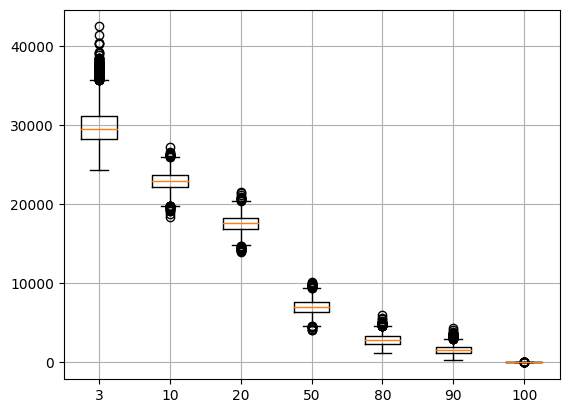

In [53]:
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.grid()
ax.set_xticklabels(d.keys())

In [63]:
import yaml
import os
import models
from torch import nn

In [85]:
# Load model
# root_pth = '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_100_erdos/no_coord_dim3/'
root_pth = '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_10_erdos/probando'

config = yaml.load(open(os.path.join(root_pth, 'config.yaml'), 'r'), Loader=yaml.FullLoader)
print(config)
device = 'cpu'

plots = config.get('plots', 0)
exp_name = config.get('exp_name', 'exp_1')
seed = config.get('seed', 1)
outf = config.get('outf', 'outputs_ae')

train = config['train']
epochs = train.get('epochs', 100)
no_cuda = train.get('no-cuda', 0)
log_interval = train.get('log_interval', 100)
test_interval = train.get('test_interval', 2)
generate_interval = train.get('generate-interval', 100)
lr = float(train.get('lr', 1e-4))

data = config['data']
dataset_name = data.get('dataset', 'community_ours')
with_pos = data.get('with_pos', 1)
n_nodes = data.get('n_nodes', 10)
  
model_dict = config['model']
model = model_dict.get('model', 'ae_egnn')
nf = model_dict.get('nf', 64)
emb_nf = model_dict.get('emb_nf', 8)
K = model_dict.get('K', 2)
attention = model_dict.get('attention', 0)
noise_dim = model_dict.get('noise_dim', 0)
n_layers = model_dict.get('n_layers', 4)
reg = float(model_dict.get('reg', 1e-3))
clamp = model_dict.get('clamp', 1)
weight_decay = float(model_dict.get('weight_decay', 1e-16))

{'plots': 0, 'exp_name': 'probando', 'seed': 1, 'outf': '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_10_erdos', 'train': {'epochs': 2, 'no-cuda': 0, 'log_interval': 100, 'test_interval': 2, 'generate-interval': 100, 'lr': '1e-4'}, 'data': {'dataset': 'erdosrenyinodes_0.25_none', 'with_pos': 0, 'n_nodes': 10}, 'model': {'model': 'ae_egnn', 'nf': 64, 'emb_nf': 8, 'K': 3, 'attention': 0, 'noise_dim': 0, 'n_layers': 4, 'reg': '1e-3', 'clamp': 1, 'weight_decay': '1e-16'}}


In [86]:
model_pth = os.path.join(root_pth, 'model.pt')
model = models.AE_EGNN(hidden_nf=nf, K=K, act_fn=nn.SiLU(), device=device, n_layers=n_layers,
                       reg=reg, clamp=clamp)

In [87]:
state_dict = torch.load(model_pth, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [88]:
state_dict.keys()

odict_keys(['w', 'b', 'gcl_0.edge_mlp.0.weight', 'gcl_0.edge_mlp.0.bias', 'gcl_0.edge_mlp.2.weight', 'gcl_0.edge_mlp.2.bias', 'gcl_0.node_mlp.0.weight', 'gcl_0.node_mlp.0.bias', 'gcl_0.node_mlp.2.weight', 'gcl_0.node_mlp.2.bias', 'gcl_0.coord_mlp.0.weight', 'gcl_0.coord_mlp.0.bias', 'gcl_0.coord_mlp.2.weight', 'gcl_1.edge_mlp.0.weight', 'gcl_1.edge_mlp.0.bias', 'gcl_1.edge_mlp.2.weight', 'gcl_1.edge_mlp.2.bias', 'gcl_1.node_mlp.0.weight', 'gcl_1.node_mlp.0.bias', 'gcl_1.node_mlp.2.weight', 'gcl_1.node_mlp.2.bias', 'gcl_1.coord_mlp.0.weight', 'gcl_1.coord_mlp.0.bias', 'gcl_1.coord_mlp.2.weight', 'gcl_2.edge_mlp.0.weight', 'gcl_2.edge_mlp.0.bias', 'gcl_2.edge_mlp.2.weight', 'gcl_2.edge_mlp.2.bias', 'gcl_2.node_mlp.0.weight', 'gcl_2.node_mlp.0.bias', 'gcl_2.node_mlp.2.weight', 'gcl_2.node_mlp.2.bias', 'gcl_2.coord_mlp.0.weight', 'gcl_2.coord_mlp.0.bias', 'gcl_2.coord_mlp.2.weight', 'gcl_3.edge_mlp.0.weight', 'gcl_3.edge_mlp.0.bias', 'gcl_3.edge_mlp.2.weight', 'gcl_3.edge_mlp.2.bias', 'gcl

In [89]:
model.state_dict().keys()

odict_keys(['w', 'b', 'gcl_0.edge_mlp.0.weight', 'gcl_0.edge_mlp.0.bias', 'gcl_0.edge_mlp.2.weight', 'gcl_0.edge_mlp.2.bias', 'gcl_0.node_mlp.0.weight', 'gcl_0.node_mlp.0.bias', 'gcl_0.node_mlp.2.weight', 'gcl_0.node_mlp.2.bias', 'gcl_0.coord_mlp.0.weight', 'gcl_0.coord_mlp.0.bias', 'gcl_0.coord_mlp.2.weight', 'gcl_1.edge_mlp.0.weight', 'gcl_1.edge_mlp.0.bias', 'gcl_1.edge_mlp.2.weight', 'gcl_1.edge_mlp.2.bias', 'gcl_1.node_mlp.0.weight', 'gcl_1.node_mlp.0.bias', 'gcl_1.node_mlp.2.weight', 'gcl_1.node_mlp.2.bias', 'gcl_1.coord_mlp.0.weight', 'gcl_1.coord_mlp.0.bias', 'gcl_1.coord_mlp.2.weight', 'gcl_2.edge_mlp.0.weight', 'gcl_2.edge_mlp.0.bias', 'gcl_2.edge_mlp.2.weight', 'gcl_2.edge_mlp.2.bias', 'gcl_2.node_mlp.0.weight', 'gcl_2.node_mlp.0.bias', 'gcl_2.node_mlp.2.weight', 'gcl_2.node_mlp.2.bias', 'gcl_2.coord_mlp.0.weight', 'gcl_2.coord_mlp.0.bias', 'gcl_2.coord_mlp.2.weight', 'gcl_3.edge_mlp.0.weight', 'gcl_3.edge_mlp.0.bias', 'gcl_3.edge_mlp.2.weight', 'gcl_3.edge_mlp.2.bias', 'gcl